In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline


In [2]:
# df = pd.read_csv('data/eth_data.csv')
# df.drop(['Coin'], 1, inplace=True)
# df[["Open", "High", "Low", "Close", "Volume", "Market Cap", "200_MA", "150_MA", "50_MA", "52W_High", "52W_Low", "Volatility"]] = df[["Open", "High", "Low", "Close", "Volume", "Market Cap", "200_MA", "150_MA", "50_MA", "52W_High", "52W_Low", "Volatility"]].apply(pd.to_numeric)
# df = df[::-1]
# df.head(7)
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'low'
hist.drop(['conversionType'], 1, inplace=True)
hist.drop(['conversionSymbol'], 1, inplace=True)
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-10-28,1.107,0.8041,0.8692,2017493.83,2.034360e+06,1.0080
2015-10-29,1.234,0.9622,1.0080,1599196.63,1.861274e+06,1.1640
2015-10-30,1.343,0.9365,1.1640,1918765.10,1.993469e+06,1.0390
2015-10-31,1.012,0.8743,1.0390,542320.19,4.842635e+05,0.8929
2015-11-01,1.072,0.8968,0.8929,466656.61,4.899477e+05,1.0500
...,...,...,...,...,...,...
2021-04-15,2545.890,2401.0700,2431.8600,531393.80,1.311251e+09,2517.0800
2021-04-16,2547.400,2306.2000,2517.0800,691735.22,1.677614e+09,2425.9600
2021-04-17,2496.710,2315.7600,2425.9600,439527.77,1.057642e+09,2318.0100


In [3]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

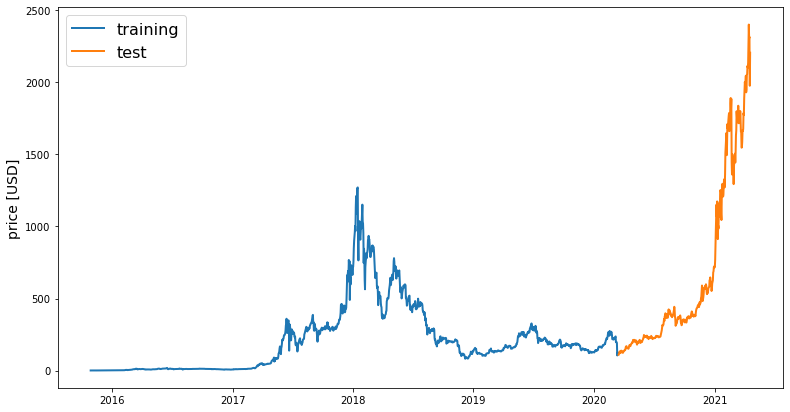

In [4]:
# Plotting The training vs Test data
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [5]:
#Normalizing Data based on Min and Max
def normalise_zero_base(df):
    return df / df.iloc[0] - 1
def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [6]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    
    return np.array(window_data)

In [7]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [8]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [9]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [10]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
50/50 [==============================] - 2s 5ms/step - loss: 0.0156
Epoch 2/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 5/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 8/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 9/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 10/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 11/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 12/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 13/20
50/50 [==============================

In [11]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.030615064702073085

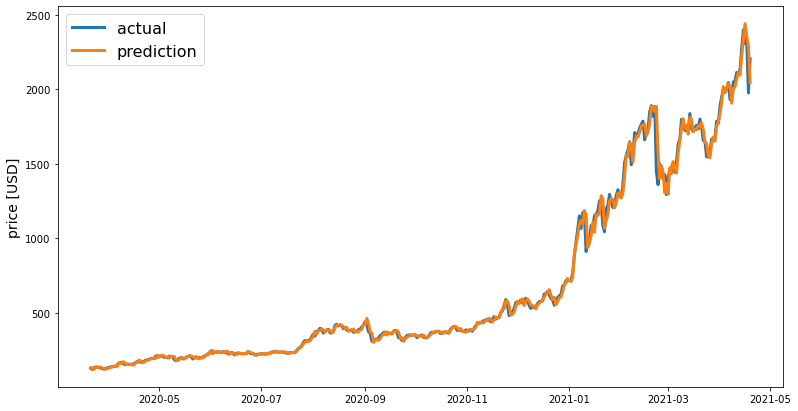

In [12]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

IndexError: list index out of range